# Setup

In [1]:
from pathlib import Path
import pandas as pd
import json
from schema import Model
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from utils import format_filesize
import os

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [3]:
def parse_experiment_id(path):
    return [segment for segment in str(path).split("/") if segment.startswith("experiment-")][0]

In [4]:
def experiment_ids(paths):
    return set([parse_experiment_id(i) for i in paths])

In [5]:
def parse_experiment_output(root_folder, metric="duration"):
    input_files = sorted(root_folder.glob("experiment-*/provenance/inputs.json"))
    output_files = sorted(root_folder.glob("experiment-*/provenance/outputs.json"))
    # success = sorted(root_folder.glob("experiment-*/SUCCESS"))
    # failed = sorted(root_folder.glob("experiment-*/FAILED"))

    successful_experiments = experiment_ids(input_files).intersection(experiment_ids(output_files))

    input_files = [f for f in input_files if parse_experiment_id(f) in successful_experiments]
    output_files = [f for f in output_files if parse_experiment_id(f) in successful_experiments]

    #assert len(success) == len(failed), "There are some failed experiments"

    provenance_results = [
        Model(
            inputs=json.loads(f.read_text()),
            outputs=json.loads(output_files[idx].read_text())
        ) for idx, f in enumerate(input_files)
    ]

    configs = {}

    data = []
    for r in provenance_results:
        config = r.inputs.parameters.setup.lower()
        dataset = r.inputs.parameters.dataset
        total_size = sum([l.size for l in r.outputs.sizes])
        sf = r.inputs.parameters.storageFormat.replace("File", "").replace("Format", "")
        compressed = "(true)" in sf or sf.lower() in ["parquet", "orc", "avro"]
        sf = sf.replace("()", "").replace("(true)", "").replace("(false)", "")
        if compressed:
            sf += "-C"

        if dataset not in configs:
            file = root_folder / "configs" / (dataset + ".properties")
            pairs = {
                line.split("=")[0].strip().replace(f"graph.{dataset}.", ""): line.split("=")[1].strip() 
                for line in open(file).read().splitlines() if "=" in line
            }
            configs[dataset] = pairs
        else:
            pairs = configs[dataset]
        
        data.append({
            "config": config,
            "algorithm": r.inputs.parameters.algorithm,
            "dataset": dataset,
            "run": r.inputs.parameters.runNr,
            "storage_format": sf,
            "compressed": compressed,
            # "output_size": r.outputs.sizes.total,
            "total_size": total_size,
            "nr_executors": r.inputs.parameters.numExecutors,
            "nr_vertices": int(pairs["meta.vertices"]),
            "iterations": len([e for e in r.outputs.graph.edges if e.type == "operation"]),
            "duration": r.outputs.duration.amount / 10**9, # in seconds
            # "size": sum([s.size for s in r.outputs.sizes.individual]),
        })
    return pd.DataFrame(data)

In [6]:
sns.set_theme(style="whitegrid", font_scale=1.5)

In [7]:
palette = sns.color_palette("tab10")

In [8]:
root_dir = Path(os.path.abspath("")).parent
plot_dir = root_dir / "plots"
root_dir, plot_dir

(PosixPath('/Users/gm/vu/thesis/code/provxlib/results'),
 PosixPath('/Users/gm/vu/thesis/code/provxlib/results/plots'))

In [9]:
def plot_location(location: Path, prefix=Path("das6") / "final") -> Path:
    parent = Path(location).parent
    wdir = plot_dir / prefix / parent
    wdir.mkdir(exist_ok=True, parents=True)
    return wdir / Path(location).name

In [10]:
def csv_location(location: Path, prefix=Path("das6") / "final" / "csv") -> Path:
    parent = Path(location).parent
    wdir = plot_dir / prefix / parent
    wdir.mkdir(exist_ok=True, parents=True)
    return wdir / Path(location).name

In [11]:
def output_table(data, metric, location):
    stats = data[["algorithm", "dataset", metric]]
    stats = stats.groupby(['algorithm', 'dataset'])[metric]
    stats = stats.agg(["mean", "std", "min", "max"]).reset_index()
    stats = stats[["algorithm", "dataset", "min", "mean", "max", "std"]]
    stats.sort_values(by=["algorithm", "mean"], ascending=True, inplace=True)
    for column in ["std", "min", "mean", "max"]:
        stats[column] = stats[column].apply(lambda x: f'{x:01.2f}')
    stats["dataset"] = [d.replace("_", "\\_") for d in stats["dataset"]]
    stats.to_csv(csv_location(location), index=False)

In [142]:
def size_table(data, location):
    stats = data[["algorithm", "dataset", "size"]]
    stats = stats.groupby(['algorithm', 'dataset'])["size"]
    stats = stats.agg(["mean", "min", "max"]).reset_index()
    stats = stats[["algorithm", "dataset", "min", "mean", "max"]]
    stats.sort_values(by=["algorithm", "mean"], ascending=True, inplace=True)
    for column in ["min", "mean", "max"]:
        stats[column] = stats[column].apply(lambda x: f"{int(format_filesize(x)[0])} {format_filesize(x)[1]}" if x != np.nan else x)
    stats["dataset"] = [d.replace("_", "\\_") for d in stats["dataset"]]
    stats.to_csv(csv_location(location), index=False)

In [12]:
data = json.loads(open("../data/sizes.json").read())
rows = []
for dataset, metrics in data.items():
    for algorithm, size in metrics.items():
        # if algorithm in ["vertices", "edges"]:
        #     continue
        alg = "PageRank" if algorithm == "PR" else algorithm
        rows.append({"algorithm": alg, "dataset": dataset, "size": size})

dataset_sizes = pd.DataFrame(rows)
node_sizes = dataset_sizes[dataset_sizes["algorithm"] == "edges"].groupby(["dataset"]).agg(["sum"]).reset_index()
node_sizes["pretty_size"] = [f"{int(format_filesize(x)[0])}{format_filesize(x)[1]}" for x in node_sizes["size"]["sum"]]
node_sizes

,dataset,algorithm,size,pretty_size
,,sum,sum,
0,cit-Patents,edges,264019585,251MB
1,datagen-7_5-fb,edges,1055107558,1006MB
2,datagen-7_9-fb,edges,2641075598,2GB
3,datagen-8_4-fb,edges,8333606244,7GB
4,datagen-8_8-zf,edges,12707008356,11GB
5,graph500-22,edges,991389885,945MB


# Baseline

In [13]:
data_dir = Path("das6") / "20240527-020405-baseline-6-runs"

baseline = parse_experiment_output(root_dir / "data" / data_dir)
baseline.sort_values(by=["algorithm", "dataset"])
baseline = baseline[(baseline["algorithm"] != "WCC") | (baseline["dataset"] != "datagen-8_8-zf")]

In [14]:
output_table(baseline, "duration", "es01-duration.csv")

In [15]:
baseline_grouped = baseline.groupby(['algorithm', 'dataset'])["duration"]
baseline_stats = baseline_grouped.agg(["mean", "std", "min", "max"]).reset_index()
baseline_stats

,algorithm,dataset,mean,std,min,max
0,BFS,cit-Patents,82.968899,4.015975,79.365607,88.440500
1,BFS,datagen-7_5-fb,34.323108,1.200316,33.200151,36.050193
2,BFS,datagen-7_9-fb,69.310011,8.003585,62.316827,80.586730
3,BFS,datagen-8_4-fb,241.785784,9.339967,224.231653,251.477808
4,BFS,datagen-8_8-zf,218.721579,26.496145,184.118673,247.358507
5,BFS,graph500-22,32.865590,1.996534,30.442835,35.109367
6,PageRank,cit-Patents,85.102944,4.449141,76.204864,88.406609
7,PageRank,datagen-7_5-fb,39.980476,2.020681,38.597518,43.881411
8,PageRank,datagen-7_9-fb,69.879073,1.650790,67.773184,71.442942
9,PageRank,datagen-8_4-fb,215.872856,7.115529,205.036952,227.362958


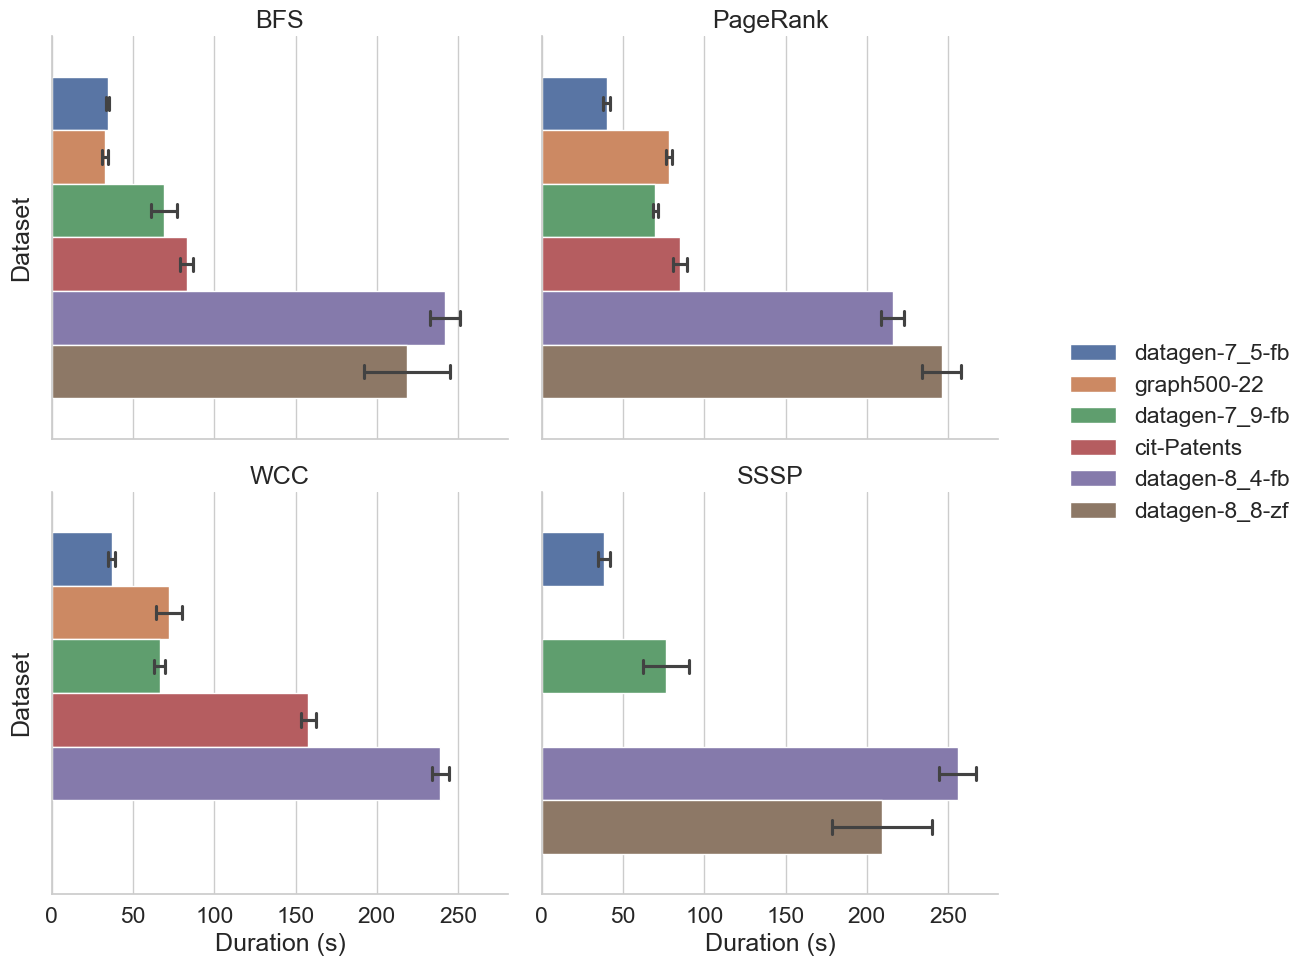

In [16]:
ax = sns.catplot(
    baseline,
    x="duration",
    col="algorithm",
    hue="dataset",
    kind="bar",
    hue_order=['datagen-7_5-fb', 'graph500-22', 'datagen-7_9-fb', 'cit-Patents', 'datagen-8_4-fb', 'datagen-8_8-zf'],
    col_order=["BFS", "PageRank", "WCC", "SSSP"],
    legend_out=True,
    errorbar="sd",
    capsize=0.2,
    col_wrap=2,
    sharex=True
)
sns.move_legend(ax, "center right", ncols=1, bbox_to_anchor=(1.05, 0.55), title=None, frameon=False)

ax.set_axis_labels("Duration (s)", "Dataset")
ax.set_titles("{col_name}")

ax.savefig(plot_location("es01-duration.pdf"), dpi="figure")

In [17]:
data = json.loads(open("../data/sizes.json").read())
rows = []
for dataset, metrics in data.items():
    for algorithm, size in metrics.items():
        if algorithm in ["vertices", "edges"]:
            continue
        alg = "PageRank" if algorithm == "PR" else algorithm
        rows.append({"algorithm": alg, "dataset": dataset, "size": size})

dataset_sizes = pd.DataFrame(rows)
dataset_sizes

,algorithm,dataset,size
0,BFS,cit-Patents,100187504
1,CDLP,cit-Patents,58187727
2,LCC,cit-Patents,113070194
3,PageRank,cit-Patents,113070194
4,WCC,cit-Patents,37635956
5,BFS,datagen-7_5-fb,9533719
6,CDLP,datagen-7_5-fb,11496370
7,LCC,datagen-7_5-fb,22202359
8,PageRank,datagen-7_5-fb,22202359
9,SSSP,datagen-7_5-fb,22202359


In [18]:
ds_size = dataset_sizes.sort_values(by=["dataset", "size"])
ds_size["pretty_size"] = [f"{int(format_filesize(x)[0])} {format_filesize(x)[1]}" for x in ds_size["size"]]
ds_size.drop(columns=["size"], inplace=True)
ds_size.rename(columns={"pretty_size": "size"}, inplace=True)
ds_size["dataset"] = [d.replace("_", "\\_") for d in ds_size["dataset"]]
ds_size.to_csv(csv_location("es01-size.csv"), index=False)

In [19]:
baseline_stats_copy = baseline_stats.copy(deep=True)
baseline_stats_copy = baseline_stats_copy[["algorithm", "dataset", "mean"]].rename(columns={"mean": "duration"})
baseline_stats_copy = pd.merge(baseline_stats_copy, dataset_sizes, on=["algorithm", "dataset"])
baseline_stats_copy

,algorithm,dataset,duration,size
0,BFS,cit-Patents,82.968899,100187504
1,BFS,datagen-7_5-fb,34.323108,9533719
2,BFS,datagen-7_9-fb,69.310011,20966038
3,BFS,datagen-8_4-fb,241.785784,57850630
4,BFS,datagen-8_8-zf,218.721579,2703435298
5,BFS,graph500-22,32.865590,23357988
6,PageRank,cit-Patents,85.102944,113070194
7,PageRank,datagen-7_5-fb,39.980476,22202359
8,PageRank,datagen-7_9-fb,69.879073,48717778
9,PageRank,datagen-8_4-fb,215.872856,134032310


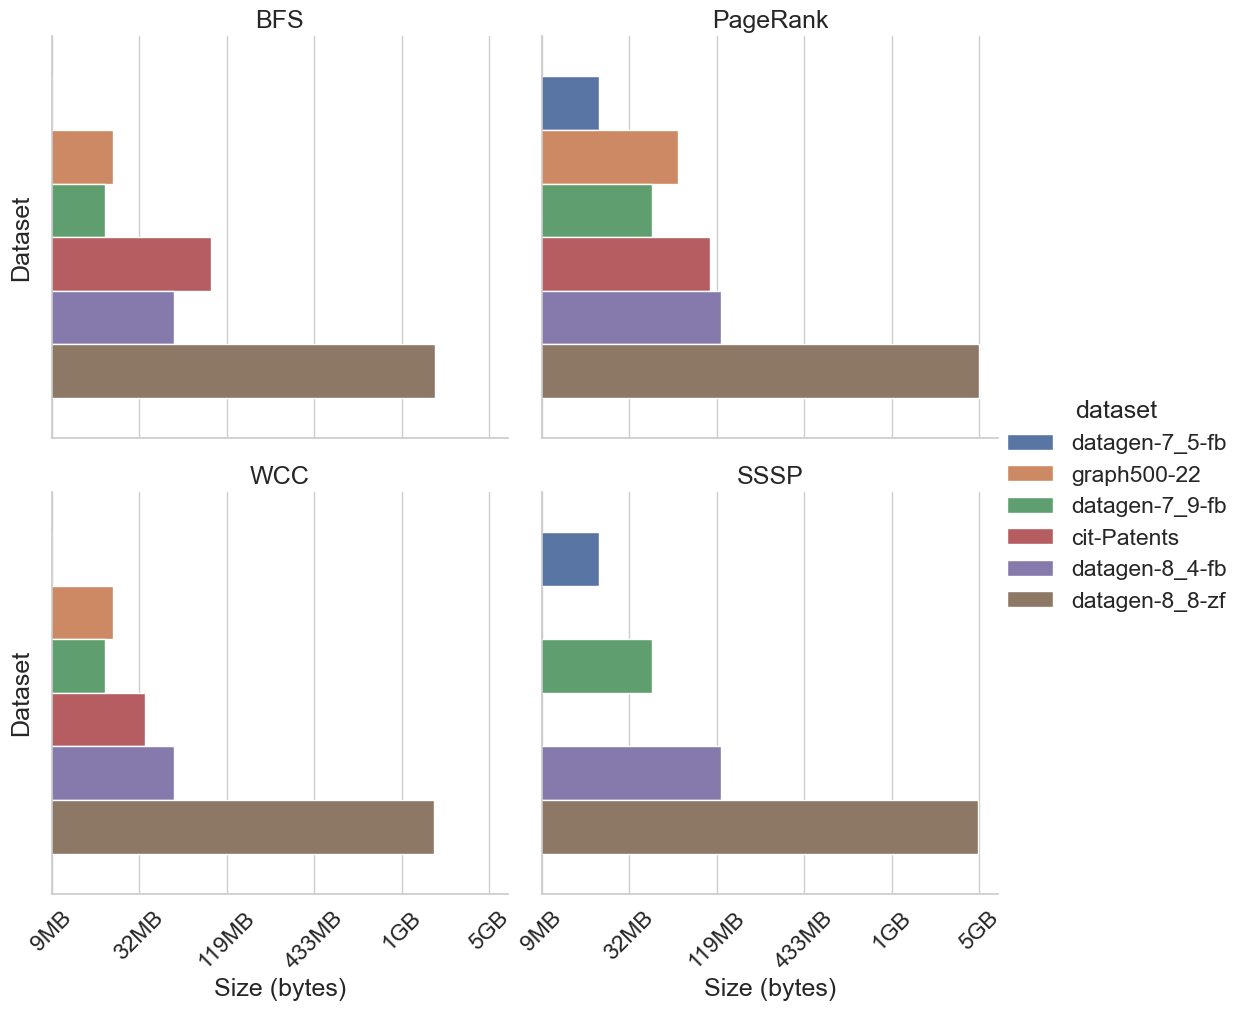

In [20]:
ax = sns.catplot(
    dataset_sizes,
    x="size",
    col="algorithm",
    hue="dataset",
    kind="bar",
    hue_order=['datagen-7_5-fb', 'graph500-22', 'datagen-7_9-fb', 'cit-Patents', 'datagen-8_4-fb', 'datagen-8_8-zf'],
    col_order=["BFS", "PageRank", "WCC", "SSSP"],
    legend_out=True,
    errorbar="sd",
    capsize=0.2,
    col_wrap=2,
    sharex=True
)

ax.set(xscale="log")
# sns.move_legend(ax, "center right", ncols=1, bbox_to_anchor=(1.05, 0.55), title=None, frameon=False)

num_xticks = 6  # Specify the number of xticks you want
xtick_min = np.log2(dataset_sizes['size'].min())
xtick_max = np.log2(dataset_sizes['size'].max())
xticks = np.logspace(xtick_min, xtick_max, num=num_xticks, base=2.0)
ax.set(xticks=xticks)

xtick_labels = [f"{int(format_filesize(x)[0])}{format_filesize(x)[1]}" for x in xticks]
ax.set_xticklabels(xtick_labels)

for axx in ax.axes.flat:
    axx.set_xticklabels(xtick_labels, rotation=45)

ax.set_axis_labels("Size (bytes)", "Dataset")
ax.set_titles("{col_name}")

ax.savefig(plot_location("es01-size.pdf"), dpi="figure")

# Tracing

In [21]:
baseline_stats_copy

,algorithm,dataset,duration,size
0,BFS,cit-Patents,82.968899,100187504
1,BFS,datagen-7_5-fb,34.323108,9533719
2,BFS,datagen-7_9-fb,69.310011,20966038
3,BFS,datagen-8_4-fb,241.785784,57850630
4,BFS,datagen-8_8-zf,218.721579,2703435298
5,BFS,graph500-22,32.865590,23357988
6,PageRank,cit-Patents,85.102944,113070194
7,PageRank,datagen-7_5-fb,39.980476,22202359
8,PageRank,datagen-7_9-fb,69.879073,48717778
9,PageRank,datagen-8_4-fb,215.872856,134032310


In [22]:
data_dir = Path("das6") / "20240527-020517-tracing-6-runs"

tracing = parse_experiment_output(root_dir / "data" / data_dir)
tracing.sort_values(by=["algorithm", "dataset", "run"])
tracing = tracing[(tracing["algorithm"] != "WCC") | (tracing["dataset"] != "datagen-8_8-zf")]
tracing = tracing[["algorithm", "dataset", "duration"]]
tracing = pd.merge(tracing, baseline_stats_copy[["algorithm", "dataset", "size"]], on=["algorithm", "dataset"])
tracing

,algorithm,dataset,duration,size
0,SSSP,datagen-8_4-fb,140.479249,134032310
1,SSSP,datagen-8_4-fb,132.204479,134032310
2,SSSP,datagen-8_4-fb,132.022222,134032310
3,SSSP,datagen-8_4-fb,178.487897,134032310
4,SSSP,datagen-8_4-fb,201.796498,134032310
5,SSSP,datagen-8_4-fb,266.424223,134032310
6,SSSP,datagen-7_5-fb,33.830519,22202359
7,SSSP,datagen-7_5-fb,42.004611,22202359
8,SSSP,datagen-7_5-fb,40.612584,22202359
9,SSSP,datagen-7_5-fb,73.230962,22202359


In [23]:
output_table(tracing, "duration", "es02-duration.csv")

In [24]:
tracing.groupby(by=["algorithm", "dataset"])["duration"].nunique().reset_index()

,algorithm,dataset,duration
0,BFS,cit-Patents,6
1,BFS,datagen-7_5-fb,6
2,BFS,datagen-7_9-fb,6
3,BFS,datagen-8_4-fb,6
4,BFS,datagen-8_8-zf,6
5,BFS,graph500-22,6
6,PageRank,cit-Patents,6
7,PageRank,datagen-7_5-fb,6
8,PageRank,datagen-7_9-fb,6
9,PageRank,datagen-8_4-fb,6


In [25]:
tracing_durations = tracing[["algorithm", "dataset", "duration"]].sort_values(by=["algorithm", "dataset"])
tracing_durations

,algorithm,dataset,duration
42,BFS,cit-Patents,93.084850
43,BFS,cit-Patents,67.314091
44,BFS,cit-Patents,71.610397
45,BFS,cit-Patents,67.837661
46,BFS,cit-Patents,68.945276
47,BFS,cit-Patents,67.387534
102,BFS,datagen-7_5-fb,43.980179
103,BFS,datagen-7_5-fb,36.284404
104,BFS,datagen-7_5-fb,64.881096
105,BFS,datagen-7_5-fb,54.294595


In [26]:
tracing_comb = pd.merge(tracing_durations, baseline_stats_copy, on=["algorithm", "dataset"], suffixes=('_tracing', '_baseline'))
tracing_comb["overhead"] = tracing_comb["duration_tracing"] / tracing_comb["duration_baseline"]
tracing_comb#.groupby(["algorithm", "dataset"]).agg(["mean","std"])

,algorithm,dataset,duration_tracing,duration_baseline,size,overhead
0,BFS,cit-Patents,93.084850,82.968899,100187504,1.121925
1,BFS,cit-Patents,67.314091,82.968899,100187504,0.811317
2,BFS,cit-Patents,71.610397,82.968899,100187504,0.863099
3,BFS,cit-Patents,67.837661,82.968899,100187504,0.817628
4,BFS,cit-Patents,68.945276,82.968899,100187504,0.830977
5,BFS,cit-Patents,67.387534,82.968899,100187504,0.812202
6,BFS,datagen-7_5-fb,43.980179,34.323108,9533719,1.281358
7,BFS,datagen-7_5-fb,36.284404,34.323108,9533719,1.057142
8,BFS,datagen-7_5-fb,64.881096,34.323108,9533719,1.890304
9,BFS,datagen-7_5-fb,54.294595,34.323108,9533719,1.581867


In [27]:
tracing_comb["overhead"].mean()

1.0585902665988494

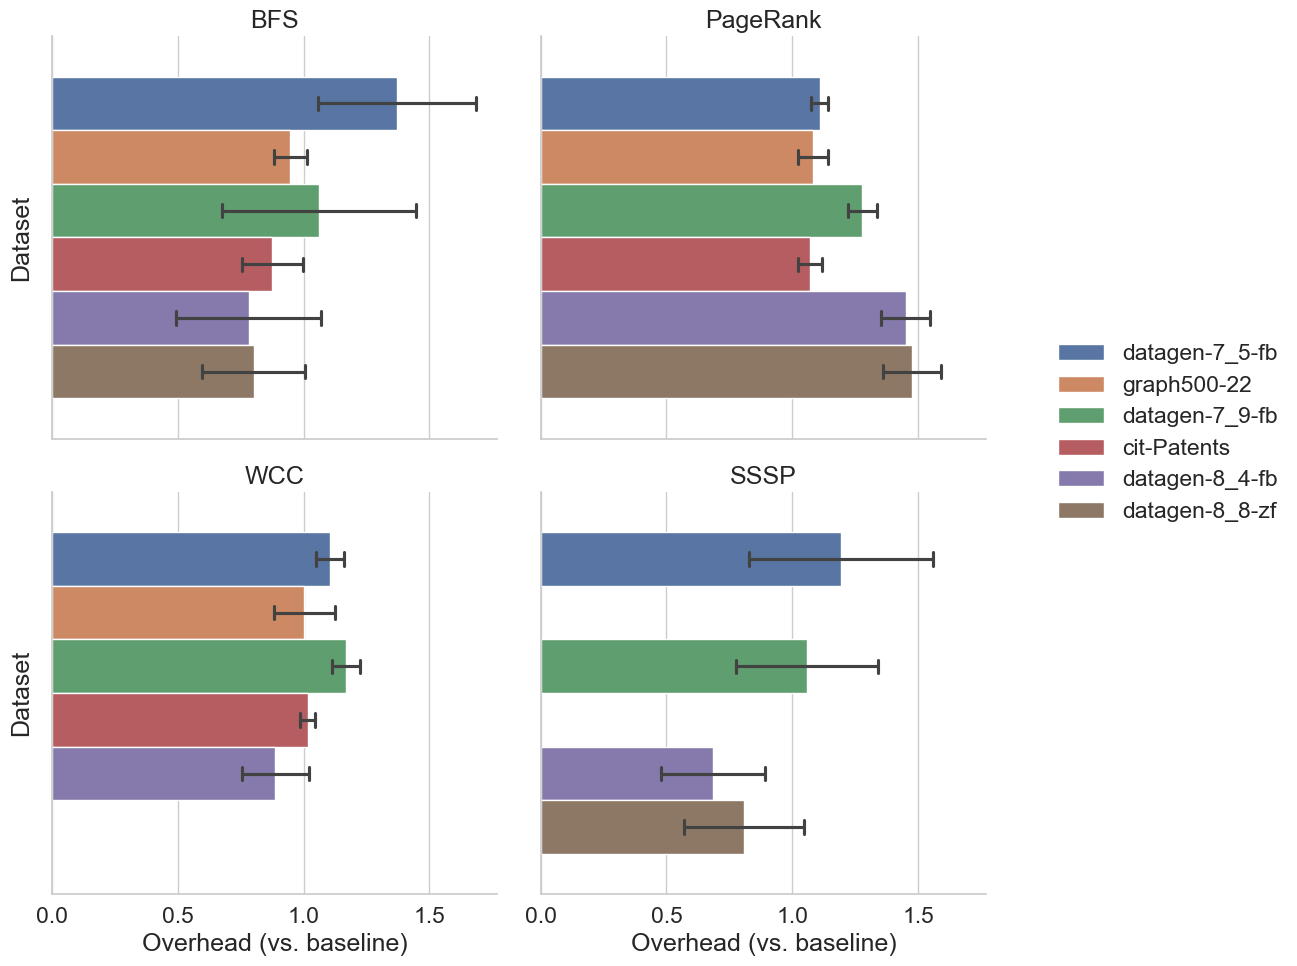

In [28]:
ax = sns.catplot(
    tracing_comb,
    x="overhead",
    col="algorithm",
    hue="dataset",
    kind="bar",
    hue_order=['datagen-7_5-fb', 'graph500-22', 'datagen-7_9-fb', 'cit-Patents', 'datagen-8_4-fb', 'datagen-8_8-zf'],
    col_order=["BFS", "PageRank", "WCC", "SSSP"],
    legend_out=True,
    errorbar="sd",
    capsize=0.2,
    col_wrap=2,
)
sns.move_legend(ax, "center right", ncols=1, bbox_to_anchor=(1.05, 0.55), title=None, frameon=False)

ax.set_axis_labels("Overhead (vs. baseline)", "Dataset")
ax.set_titles("{col_name}")

ax.savefig(plot_location("es02-overhead-duration.pdf"), dpi="figure")

# Complete provenance (storage formats)

In [30]:
data_dir = Path("das6") / "20240527-182846-complete-provenance-textonly"

storage_formats_text = parse_experiment_output(root_dir / "data" / data_dir)
storage_formats_text = storage_formats_text[["algorithm", "dataset", "total_size", "duration"]]
storage_formats_text

,algorithm,dataset,total_size,duration
0,BFS,graph500-22,213794112,37.135303
1,SSSP,datagen-7_9-fb,601133226,98.981582
2,PageRank,datagen-8_4-fb,3331385809,362.998825
3,BFS,datagen-7_5-fb,256529225,43.167773
4,WCC,graph500-22,268114309,72.910509
5,PageRank,datagen-8_8-zf,40426605492,889.399285
6,BFS,cit-Patents,2525597803,111.367214
7,BFS,datagen-7_9-fb,581855399,90.477825
8,WCC,datagen-7_5-fb,94026180,43.913258
9,BFS,datagen-8_4-fb,1929106864,229.720098


In [31]:
data_dir = Path("das6") / "20240521-034221-completeprovenance"
storage_formats = parse_experiment_output(root_dir / "data" / data_dir)
storage_formats = storage_formats[["algorithm", "dataset", "storage_format", "total_size", "duration"]]
storage_formats_text_replacement = storage_formats_text.copy(deep=True)
storage_formats_text_replacement["storage_format"] = "Text"


storage_formats = storage_formats[storage_formats["storage_format"] != "Text"]
storage_formats = pd.concat([storage_formats, storage_formats_text_replacement], ignore_index=True)
storage_formats

,algorithm,dataset,storage_format,total_size,duration
0,BFS,datagen-7_5-fb,ORC,58274920,50.868484
1,BFS,graph500-22,Parquet,36196251,43.212258
2,PageRank,datagen-7_9-fb,JSON,1632380079,124.243249
3,PageRank,datagen-7_9-fb,JSON-C,457450553,156.334777
4,BFS,datagen-7_9-fb,ORC,135877889,104.052758
5,BFS,datagen-7_9-fb,JSON,864923147,67.917724
6,SSSP,datagen-7_9-fb,JSON-C,170232558,111.011642
7,WCC,cit-Patents,CSV,941792868,200.797959
8,SSSP,datagen-7_5-fb,JSON-C,68791112,59.969305
9,WCC,datagen-7_9-fb,CSV-C,57549288,84.314303


In [32]:
storage_formats[storage_formats["storage_format"] == "Text"]

,algorithm,dataset,storage_format,total_size,duration
106,BFS,graph500-22,Text,213794112,37.135303
107,SSSP,datagen-7_9-fb,Text,601133226,98.981582
108,PageRank,datagen-8_4-fb,Text,3331385809,362.998825
109,BFS,datagen-7_5-fb,Text,256529225,43.167773
110,WCC,graph500-22,Text,268114309,72.910509
111,PageRank,datagen-8_8-zf,Text,40426605492,889.399285
112,BFS,cit-Patents,Text,2525597803,111.367214
113,BFS,datagen-7_9-fb,Text,581855399,90.477825
114,WCC,datagen-7_5-fb,Text,94026180,43.913258
115,BFS,datagen-8_4-fb,Text,1929106864,229.720098


In [33]:
# storage_baseline = storage_formats[storage_formats["storage_format"] == "Text"].copy(deep=True)
# storage_baseline.drop(["storage_format"], axis=1, inplace=True)
# storage_baseline.rename(columns={"total_size": "size"}, inplace=True)
# storage_baseline.sort_values(by=["algorithm", "dataset"])
# pd.merge(storage_baseline, dataset_sizes, on=["algorithm", "dataset"], suffixes=("_storageformats", "_baseline"))

storage_baseline = storage_formats_text
storage_baseline


,algorithm,dataset,total_size,duration
0,BFS,graph500-22,213794112,37.135303
1,SSSP,datagen-7_9-fb,601133226,98.981582
2,PageRank,datagen-8_4-fb,3331385809,362.998825
3,BFS,datagen-7_5-fb,256529225,43.167773
4,WCC,graph500-22,268114309,72.910509
5,PageRank,datagen-8_8-zf,40426605492,889.399285
6,BFS,cit-Patents,2525597803,111.367214
7,BFS,datagen-7_9-fb,581855399,90.477825
8,WCC,datagen-7_5-fb,94026180,43.913258
9,BFS,datagen-8_4-fb,1929106864,229.720098


In [34]:
storage_comp = pd.merge(storage_formats, storage_baseline, on=["algorithm", "dataset"], suffixes=('_storageformats', '_baseline'))
storage_comp["overhead_duration"] = storage_comp["duration_storageformats"] / storage_comp["duration_baseline"]
storage_comp["overhead_size"] = storage_comp["total_size_storageformats"] / storage_comp["total_size_baseline"]
storage_comp

,algorithm,dataset,storage_format,total_size_storageformats,duration_storageformats,total_size_baseline,duration_baseline,overhead_duration,overhead_size
0,BFS,datagen-7_5-fb,ORC,58274920,50.868484,256529225,43.167773,1.178390,0.227167
1,BFS,datagen-7_5-fb,Object,487601995,41.675332,256529225,43.167773,0.965427,1.900766
2,BFS,datagen-7_5-fb,Text-C,49265960,57.709867,256529225,43.167773,1.336874,0.192048
3,BFS,datagen-7_5-fb,JSON,378148169,48.643720,256529225,43.167773,1.126853,1.474094
4,BFS,datagen-7_5-fb,CSV,236259401,58.527642,256529225,43.167773,1.355818,0.920984
5,BFS,datagen-7_5-fb,Avro,72546300,53.117164,256529225,43.167773,1.230482,0.282799
6,BFS,datagen-7_5-fb,JSON-C,53194680,57.547191,256529225,43.167773,1.333105,0.207363
7,BFS,datagen-7_5-fb,Parquet,61961248,48.867018,256529225,43.167773,1.132025,0.241537
8,BFS,datagen-7_5-fb,CSV-C,48690774,57.120579,256529225,43.167773,1.323223,0.189806
9,BFS,datagen-7_5-fb,Text,256529225,43.167773,256529225,43.167773,1.000000,1.000000


In [145]:
s = storage_comp[["algorithm", "dataset", "total_size_storageformats"]].rename(columns={"total_size_storageformats": "size"})
s["size"] = s["size"].abs()
size_table(s, "es03-size.csv")

In [132]:


output_table(storage_comp[["algorithm", "dataset", "duration_storageformats"]], "duration_storageformats", "es03-duration.csv")

## Duration

In [36]:
st_order = storage_comp[(storage_comp["algorithm"] == "BFS")].groupby(by=["storage_format"])["overhead_duration"].mean().reset_index()
st_order = list(st_order.sort_values(by=["overhead_duration"])["storage_format"])
st_order

['JSON',
 'Text',
 'Avro',
 'Object',
 'CSV',
 'ORC',
 'Parquet',
 'Text-C',
 'JSON-C',
 'CSV-C']

/var/folders/4z/sr1jzyjd3sjfsw6tlm7k49180000gn/T/ipykernel_95864/450963490.py:1: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax = sns.catplot(


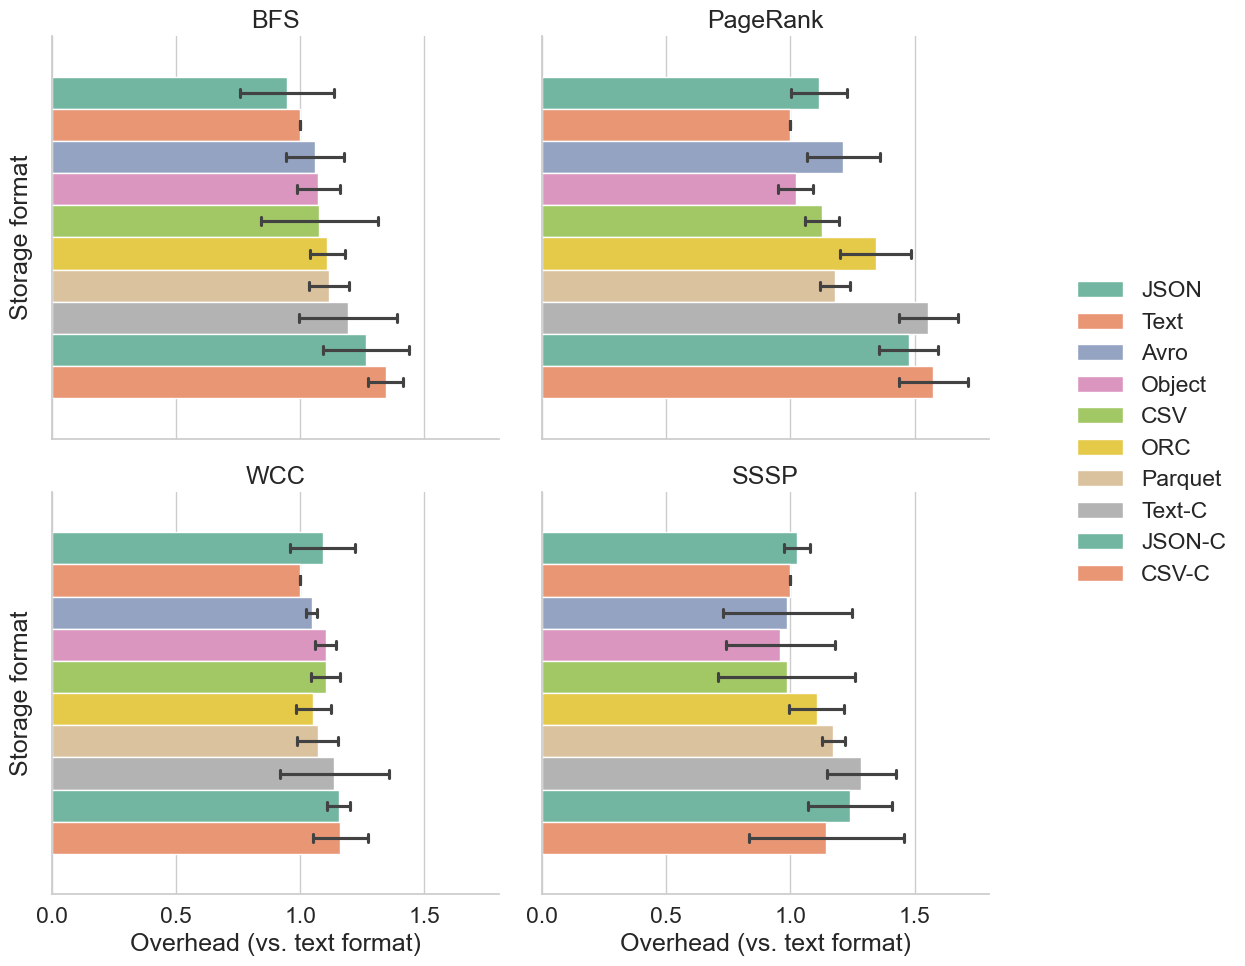

In [37]:
ax = sns.catplot(
    storage_comp,
    x="overhead_duration",
    col="algorithm",
    hue="storage_format",
    kind="bar",
    hue_order=st_order,
    #hue_order=['datagen-7_5-fb', 'graph500-22', 'datagen-7_9-fb', 'cit-Patents', 'datagen-8_4-fb', 'datagen-8_8-zf'],
    col_order=["BFS", "PageRank", "WCC", "SSSP"],
    legend_out=True,
    errorbar="sd",
    capsize=0.2,
    col_wrap=2,
    palette=sns.color_palette("Set2")
)
sns.move_legend(ax, "center right", ncols=1, bbox_to_anchor=(1.05, 0.55), title=None, frameon=False)

ax.set_axis_labels("Overhead (vs. text format)", "Storage format")
ax.set_titles("{col_name}")

ax.savefig(plot_location("es03-overhead-duration.pdf"), dpi="figure")

## Sizes

In [38]:
st_order = storage_comp[(storage_comp["algorithm"] == "BFS")].groupby(by=["storage_format"])["overhead_size"].mean().reset_index()
st_order = list(st_order.sort_values(by=["overhead_size"])["storage_format"])
st_order

['ORC',
 'Text-C',
 'CSV-C',
 'JSON-C',
 'Parquet',
 'Avro',
 'CSV',
 'Text',
 'JSON',
 'Object']

In [39]:
storage_comp[storage_comp["storage_format"] == "JSON-C"]["overhead_size"].mean()

0.28651002069881726

/var/folders/4z/sr1jzyjd3sjfsw6tlm7k49180000gn/T/ipykernel_95864/4214662472.py:1: UserWarning: 
The palette list has fewer values (8) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax = sns.catplot(


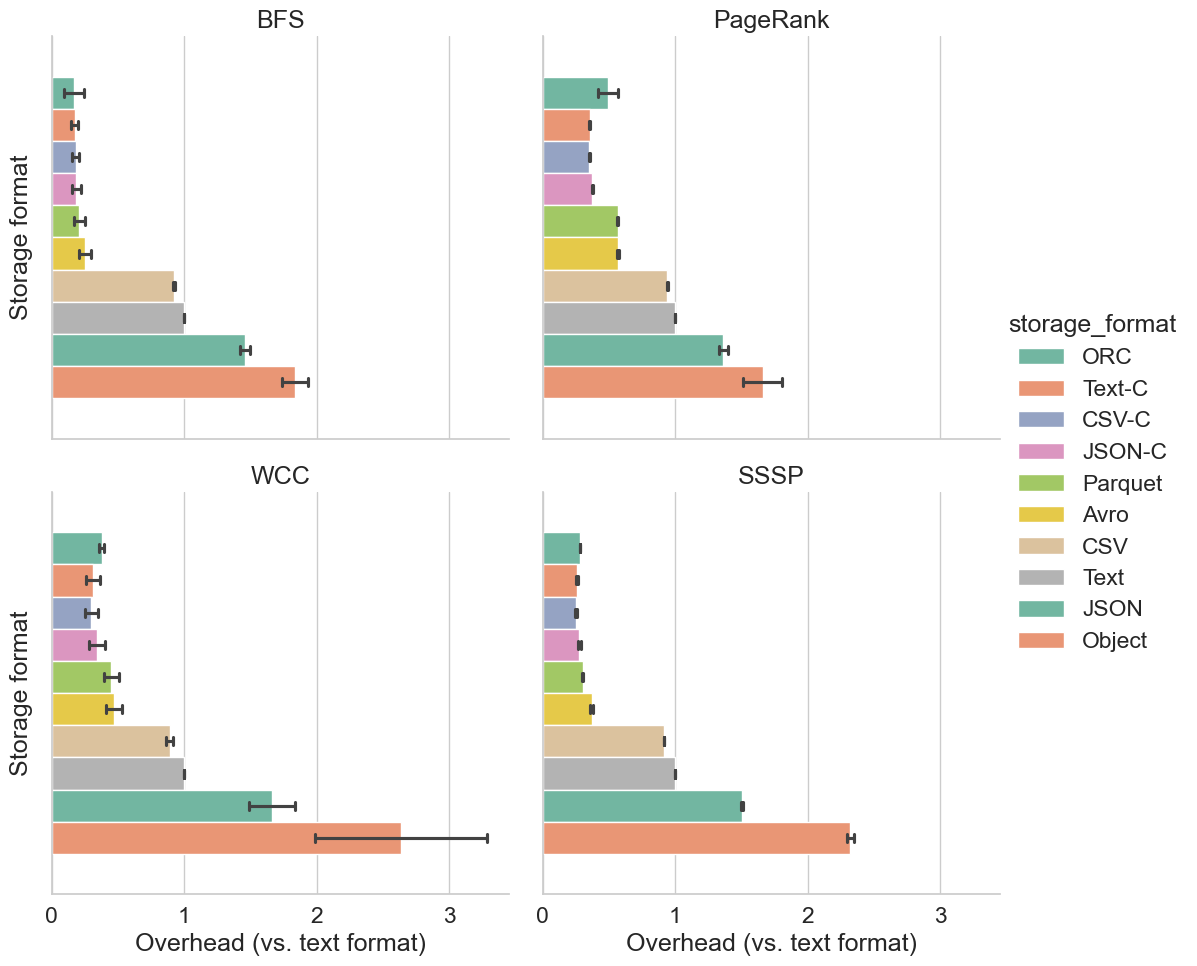

In [40]:
ax = sns.catplot(
    storage_comp,
    x="overhead_size",
    col="algorithm",
    hue="storage_format",
    kind="bar",
    hue_order=st_order,
    col_order=["BFS", "PageRank", "WCC", "SSSP"],
    legend_out=True,
    errorbar="sd",
    capsize=0.2,
    col_wrap=2,
    sharex=True,
    palette=sns.color_palette("Set2")
)

# ax.set(xscale="log")
# # sns.move_legend(ax, "center right", ncols=1, bbox_to_anchor=(1.05, 0.55), title=None, frameon=False)

# num_xticks = 6  # Specify the number of xticks you want
# xtick_min = np.log2(dataset_sizes['size'].min())
# xtick_max = np.log2(dataset_sizes['size'].max())
# xticks = np.logspace(xtick_min, xtick_max, num=num_xticks, base=2.0)
# ax.set(xticks=xticks)

# xtick_labels = [f"{int(format_filesize(x)[0])}{format_filesize(x)[1]}" for x in xticks]
# ax.set_xticklabels(xtick_labels)

# for axx in ax.axes.flat:
#     axx.set_xticklabels(xtick_labels, rotation=45)

ax.set_axis_labels("Overhead (vs. text format)", "Storage format")
ax.set_titles("{col_name}")

ax.savefig(plot_location("es03-overhead-size.pdf"), dpi="figure")

# Provenance graph pruning (`joinVertices` op only)

In [41]:
data_dir = Path("das6") / "20240528-032519-provenancegraphpruning-3-runs"

pg_pruning = parse_experiment_output(root_dir / "data" / data_dir)
#pg_pruning = pg_pruning[["algorithm", "dataset", "total_size", "duration"]].rename(columns={"total_size": "size"})
pg_pruning = pg_pruning.sort_values(by=["algorithm", "dataset"])
pg_pruning.rename(columns={"total_size": "size"}, inplace=True)
pg_pruning

,config,algorithm,dataset,run,storage_format,compressed,size,nr_executors,nr_vertices,iterations,duration
23,provenancegraphpruning,BFS,cit-Patents,3,Text,False,2186387275,7,3774768,43,126.970801
45,provenancegraphpruning,BFS,cit-Patents,2,Text,False,2186387275,7,3774768,43,117.826207
47,provenancegraphpruning,BFS,cit-Patents,1,Text,False,2186387275,7,3774768,43,111.474789
51,provenancegraphpruning,BFS,datagen-7_5-fb,1,Text,False,189922202,7,633432,29,37.921101
52,provenancegraphpruning,BFS,datagen-7_5-fb,3,Text,False,189922202,7,633432,29,42.658744
60,provenancegraphpruning,BFS,datagen-7_5-fb,2,Text,False,189922202,7,633432,29,39.946944
26,provenancegraphpruning,BFS,datagen-7_9-fb,3,Text,False,435702119,7,1387587,31,81.300645
32,provenancegraphpruning,BFS,datagen-7_9-fb,2,Text,False,435702119,7,1387587,31,87.885366
58,provenancegraphpruning,BFS,datagen-7_9-fb,1,Text,False,435702119,7,1387587,31,77.674501
18,provenancegraphpruning,BFS,datagen-8_4-fb,1,Text,False,1527009988,7,3809084,35,268.192761


In [42]:
pg_pruning_compare = pd.merge(pg_pruning, baseline_stats_copy, on=["algorithm", "dataset"], suffixes=("_pgpruning", "_baseline"))
pg_pruning_compare["overhead_duration"] = pg_pruning_compare["duration_pgpruning"] / pg_pruning_compare["duration_baseline"]
pg_pruning_compare["overhead_size"] = pg_pruning_compare["size_pgpruning"] / pg_pruning_compare["size_baseline"]
pg_pruning_compare = pg_pruning_compare[pg_pruning_compare["size_pgpruning"] > 0]
pg_pruning_compare = pg_pruning_compare[pg_pruning_compare["dataset"] != "datagen-8_8-zf"]

In [43]:
pg_pruning_compare.groupby(["algorithm"])["overhead_duration"].agg(["min", "mean", "max"])

,min,mean,max
algorithm,,,
BFS,1.096122,1.222655,1.530342
PageRank,1.261497,1.410206,1.545867
SSSP,0.942489,1.129889,1.458903
WCC,0.929364,1.079345,1.218070


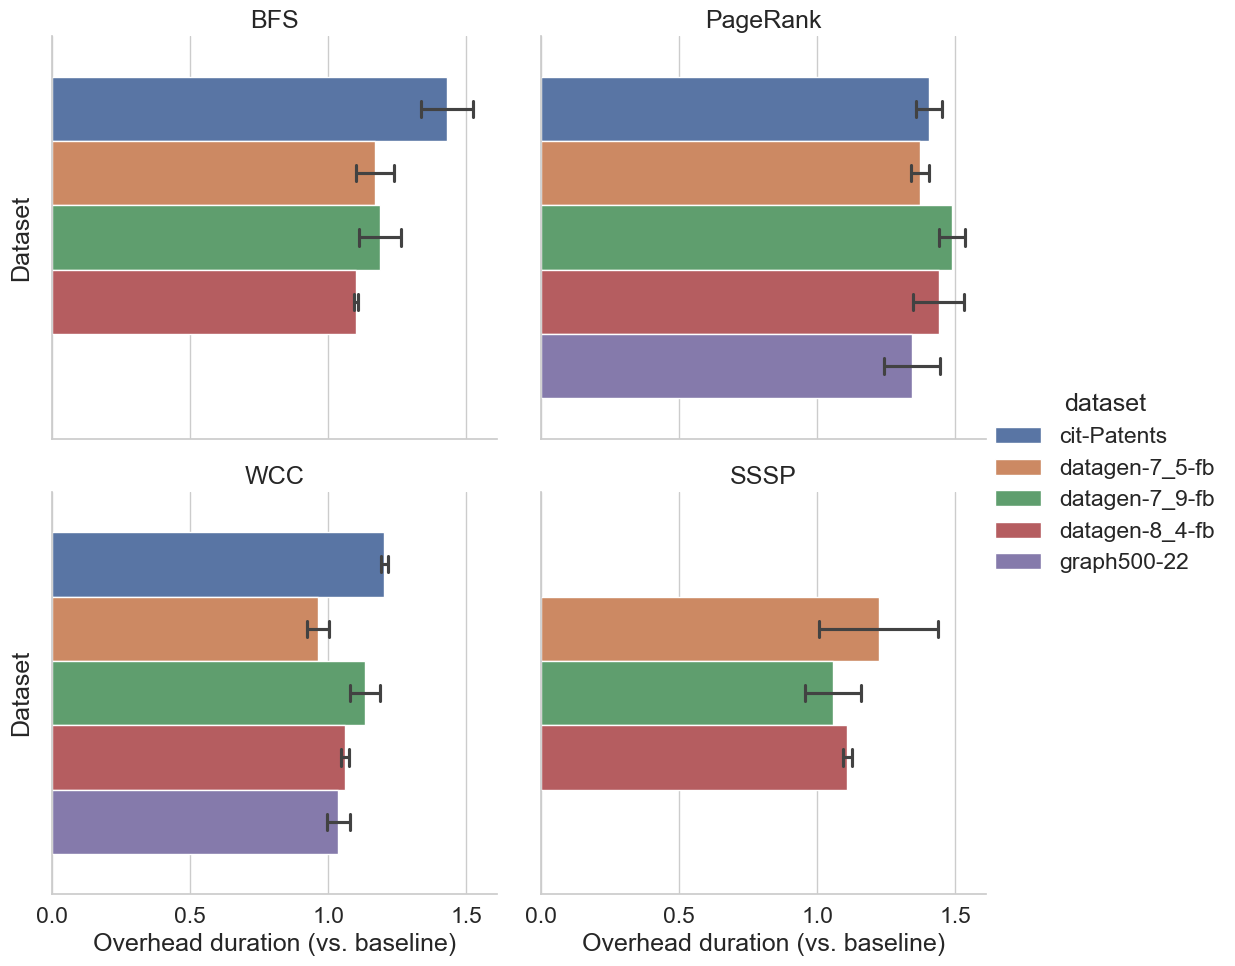

In [44]:
ax = sns.catplot(
    pg_pruning_compare,
    x="overhead_duration",
    col="algorithm",
    hue="dataset",
    kind="bar",
    col_order=["BFS", "PageRank", "WCC", "SSSP"],
    legend_out=True,
    errorbar="sd",
    capsize=0.2,
    col_wrap=2,
)

ax.set_axis_labels("Overhead duration (vs. baseline)", "Dataset")
ax.set_titles("{col_name}")

ax.savefig(plot_location("es04-overhead-duration.pdf"), dpi="figure")

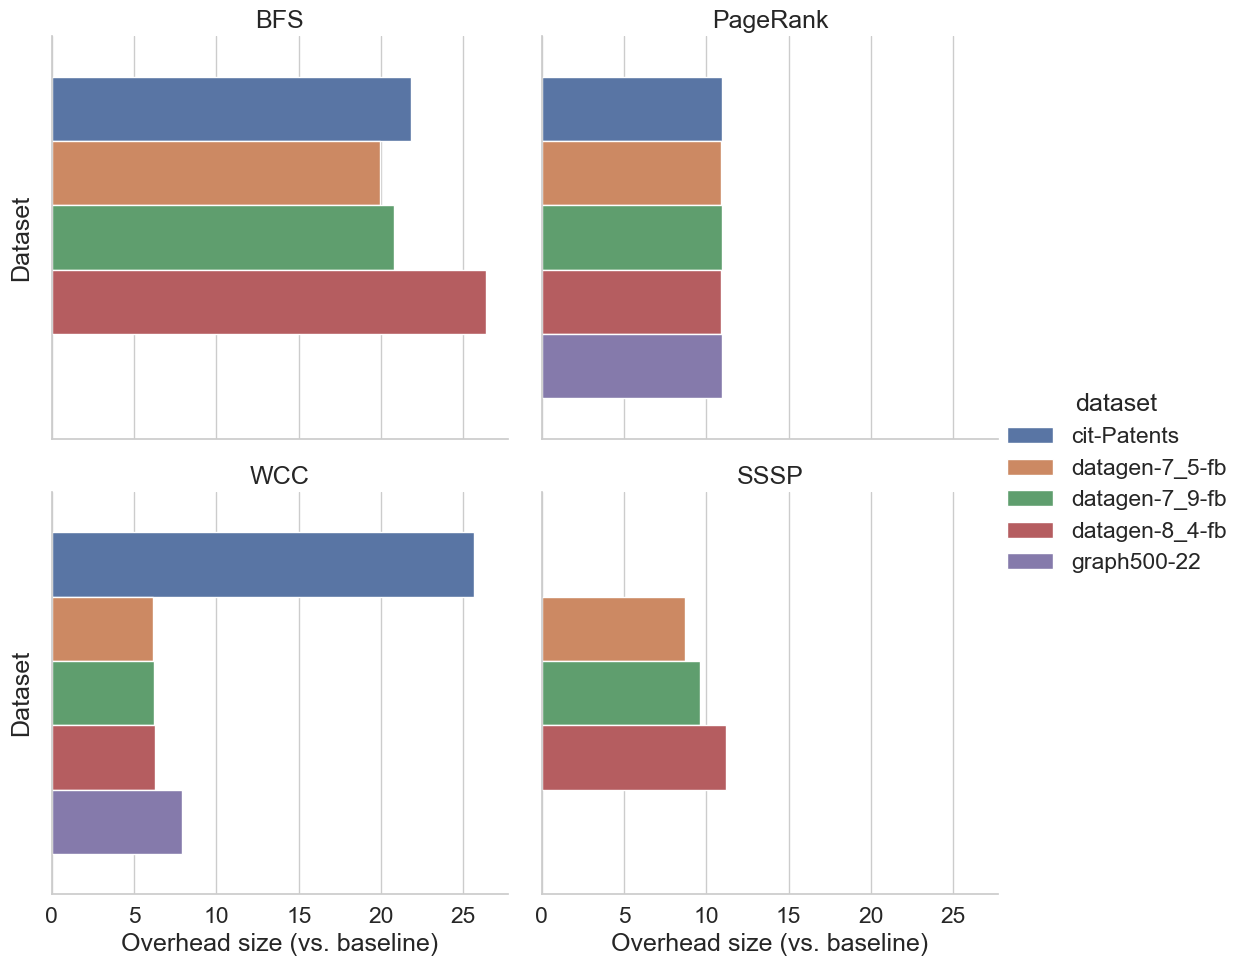

In [45]:
ax = sns.catplot(
    pg_pruning_compare,
    x="overhead_size",
    col="algorithm",
    hue="dataset",
    kind="bar",
    col_order=["BFS", "PageRank", "WCC", "SSSP"],
    legend_out=True,
    errorbar=None,
    capsize=0.2,
    col_wrap=2,
)

ax.set_axis_labels("Overhead size (vs. baseline)", "Dataset")
ax.set_titles("{col_name}")

ax.savefig(plot_location("es04-overhead-size.pdf"), dpi="figure")

# Data graph pruning

In [46]:
data_dir = Path("das6") / "20240528-032640-datagraphpruning-3-runs"

dg_pruning = parse_experiment_output(root_dir / "data" / data_dir)
dg_pruning.sort_values(by=["algorithm", "dataset", "storage_format"])
dg_pruning = dg_pruning[["algorithm", "dataset", "total_size", "duration"]].sort_values(by=["algorithm", "dataset"]).rename(columns={"total_size": "size"})
dg_pruning

,algorithm,dataset,size,duration
8,BFS,cit-Patents,50535370,84.119626
41,BFS,cit-Patents,50535370,80.565514
43,BFS,cit-Patents,50535370,71.694267
3,BFS,datagen-7_5-fb,99098478,39.527252
11,BFS,datagen-7_5-fb,99098478,39.971409
46,BFS,datagen-7_5-fb,99098478,58.515435
28,BFS,datagen-7_9-fb,242483171,60.902666
34,BFS,datagen-7_9-fb,242483171,79.564720
44,BFS,datagen-7_9-fb,242483171,60.982929
17,BFS,datagen-8_4-fb,627415867,224.443267


In [47]:
dg_pruning_compare = pd.merge(dg_pruning, baseline_stats_copy, on=["algorithm", "dataset"], suffixes=("_dgpruning", "_baseline"))
dg_pruning_compare["overhead_duration"] = dg_pruning_compare["duration_dgpruning"] / dg_pruning_compare["duration_baseline"]
dg_pruning_compare["overhead_size"] = dg_pruning_compare["size_dgpruning"] / dg_pruning_compare["size_baseline"]
dg_pruning_compare = dg_pruning_compare[~(dg_pruning_compare["duration_dgpruning"] > 1300)]
dg_pruning_compare

,algorithm,dataset,size_dgpruning,duration_dgpruning,duration_baseline,size_baseline,overhead_duration,overhead_size
0,BFS,cit-Patents,50535370,84.119626,82.968899,100187504,1.013869,0.504408
1,BFS,cit-Patents,50535370,80.565514,82.968899,100187504,0.971033,0.504408
2,BFS,cit-Patents,50535370,71.694267,82.968899,100187504,0.864110,0.504408
3,BFS,datagen-7_5-fb,99098478,39.527252,34.323108,9533719,1.151622,10.394525
4,BFS,datagen-7_5-fb,99098478,39.971409,34.323108,9533719,1.164563,10.394525
5,BFS,datagen-7_5-fb,99098478,58.515435,34.323108,9533719,1.704841,10.394525
6,BFS,datagen-7_9-fb,242483171,60.902666,69.310011,20966038,0.878699,11.565522
7,BFS,datagen-7_9-fb,242483171,79.564720,69.310011,20966038,1.147954,11.565522
8,BFS,datagen-7_9-fb,242483171,60.982929,69.310011,20966038,0.879857,11.565522
9,BFS,datagen-8_4-fb,627415867,224.443267,241.785784,57850630,0.928273,10.845446


## Duration

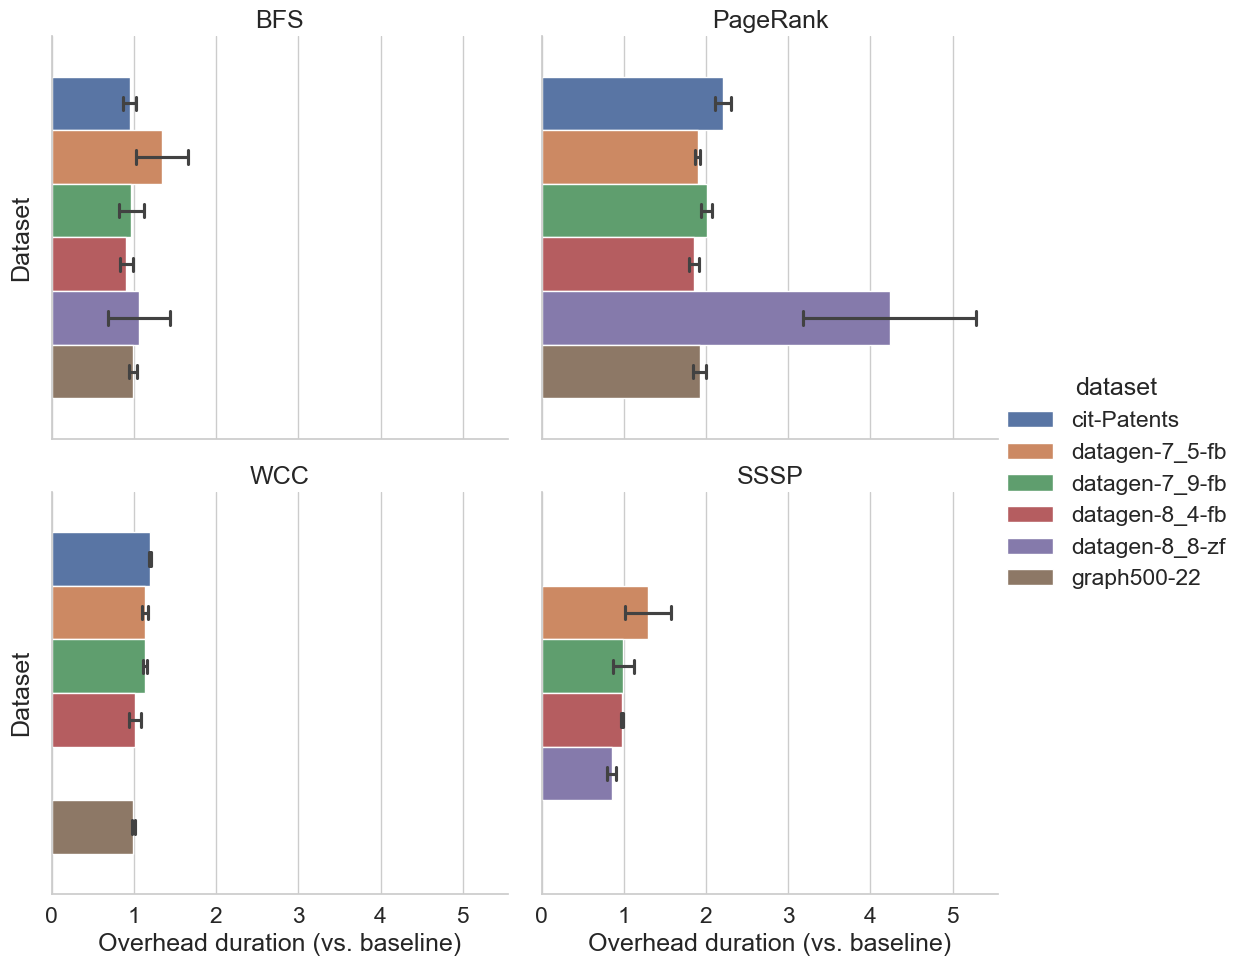

In [48]:
ax = sns.catplot(
    dg_pruning_compare,
    x="overhead_duration",
    col="algorithm",
    hue="dataset",
    kind="bar",
    col_order=["BFS", "PageRank", "WCC", "SSSP"],
    legend_out=True,
    errorbar="sd",
    capsize=0.2,
    col_wrap=2,
)

ax.set_axis_labels("Overhead duration (vs. baseline)", "Dataset")
ax.set_titles("{col_name}")

ax.savefig(plot_location("es05-overhead-duration.pdf"), dpi="figure")

## Size

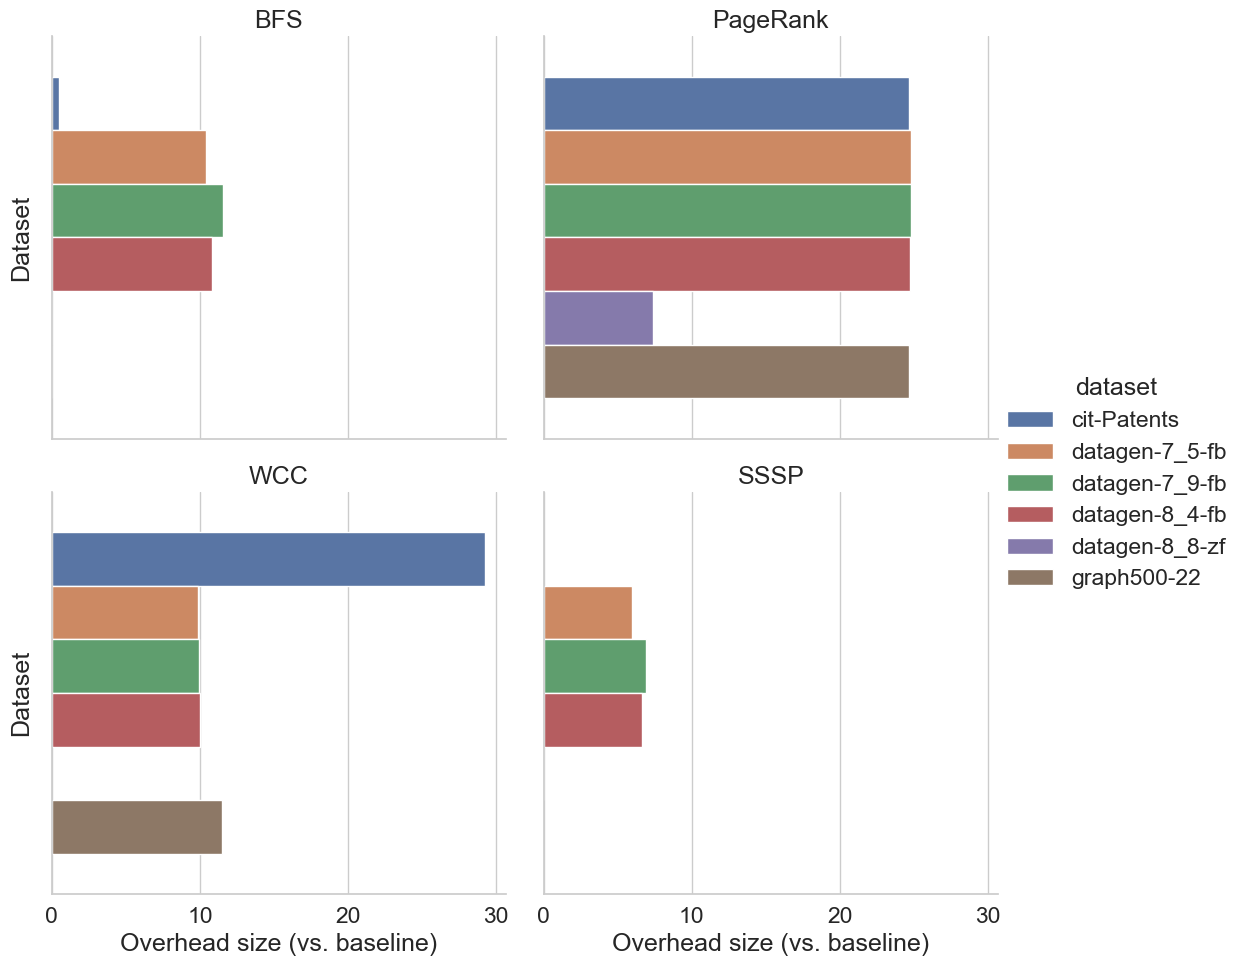

In [49]:
ax = sns.catplot(
    dg_pruning_compare,
    x="overhead_size",
    col="algorithm",
    hue="dataset",
    kind="bar",
    #hue_order=['datagen-7_5-fb', 'graph500-22', 'datagen-7_9-fb', 'cit-Patents', 'datagen-8_4-fb', 'datagen-8_8-zf'],
    col_order=["BFS", "PageRank", "WCC", "SSSP"],
    legend_out=True,
    errorbar=None,
    capsize=0.2,
    col_wrap=2,
)
# sns.move_legend(ax, "center right", ncols=1, bbox_to_anchor=(1.05, 0.55), title=None, frameon=False)

ax.set_axis_labels("Overhead size (vs. baseline)", "Dataset")
ax.set_titles("{col_name}")

ax.savefig(plot_location("es05-overhead-size.pdf"), dpi="figure")

# Combined pruning

In [50]:
data_dir = Path("das6") / "20240528-034100-combinedpruning-3-runs"

combined = parse_experiment_output(root_dir / "data" / data_dir)
combined = combined.sort_values(by=["algorithm", "dataset", "storage_format"])
combined = combined[["algorithm", "dataset", "total_size", "duration"]].rename(columns={"total_size": "size"})
combined

,algorithm,dataset,size,duration
34,BFS,cit-Patents,50535334,86.595101
39,BFS,cit-Patents,50535334,84.816436
40,BFS,cit-Patents,50535334,90.772743
32,BFS,datagen-7_5-fb,99098460,47.654069
43,BFS,datagen-7_5-fb,99098460,47.914694
61,BFS,datagen-7_5-fb,99098460,49.001435
1,BFS,datagen-7_9-fb,242483153,89.260519
13,BFS,datagen-7_9-fb,242483153,84.558765
36,BFS,datagen-7_9-fb,242483153,89.686504
9,BFS,datagen-8_4-fb,627415849,255.926213


In [51]:
combined_compare = pd.merge(combined, baseline_stats_copy, on=["algorithm", "dataset"], suffixes=("_combined", "_baseline"))
combined_compare["overhead_duration"] = combined_compare["duration_combined"] / combined_compare["duration_baseline"]
combined_compare["overhead_size"] = combined_compare["size_combined"] / combined_compare["size_baseline"]
combined_compare

,algorithm,dataset,size_combined,duration_combined,duration_baseline,size_baseline,overhead_duration,overhead_size
0,BFS,cit-Patents,50535334,86.595101,82.968899,100187504,1.043706,0.504408
1,BFS,cit-Patents,50535334,84.816436,82.968899,100187504,1.022268,0.504408
2,BFS,cit-Patents,50535334,90.772743,82.968899,100187504,1.094057,0.504408
3,BFS,datagen-7_5-fb,99098460,47.654069,34.323108,9533719,1.388396,10.394523
4,BFS,datagen-7_5-fb,99098460,47.914694,34.323108,9533719,1.395989,10.394523
5,BFS,datagen-7_5-fb,99098460,49.001435,34.323108,9533719,1.427651,10.394523
6,BFS,datagen-7_9-fb,242483153,89.260519,69.310011,20966038,1.287845,11.565521
7,BFS,datagen-7_9-fb,242483153,84.558765,69.310011,20966038,1.220008,11.565521
8,BFS,datagen-7_9-fb,242483153,89.686504,69.310011,20966038,1.293991,11.565521
9,BFS,datagen-8_4-fb,627415849,255.926213,241.785784,57850630,1.058483,10.845445


In [52]:
combined_compare[(combined_compare["algorithm"] == "BFS") & (combined_compare["dataset"] == "cit-Patents")]

,algorithm,dataset,size_combined,duration_combined,duration_baseline,size_baseline,overhead_duration,overhead_size
0,BFS,cit-Patents,50535334,86.595101,82.968899,100187504,1.043706,0.504408
1,BFS,cit-Patents,50535334,84.816436,82.968899,100187504,1.022268,0.504408
2,BFS,cit-Patents,50535334,90.772743,82.968899,100187504,1.094057,0.504408


## Duration

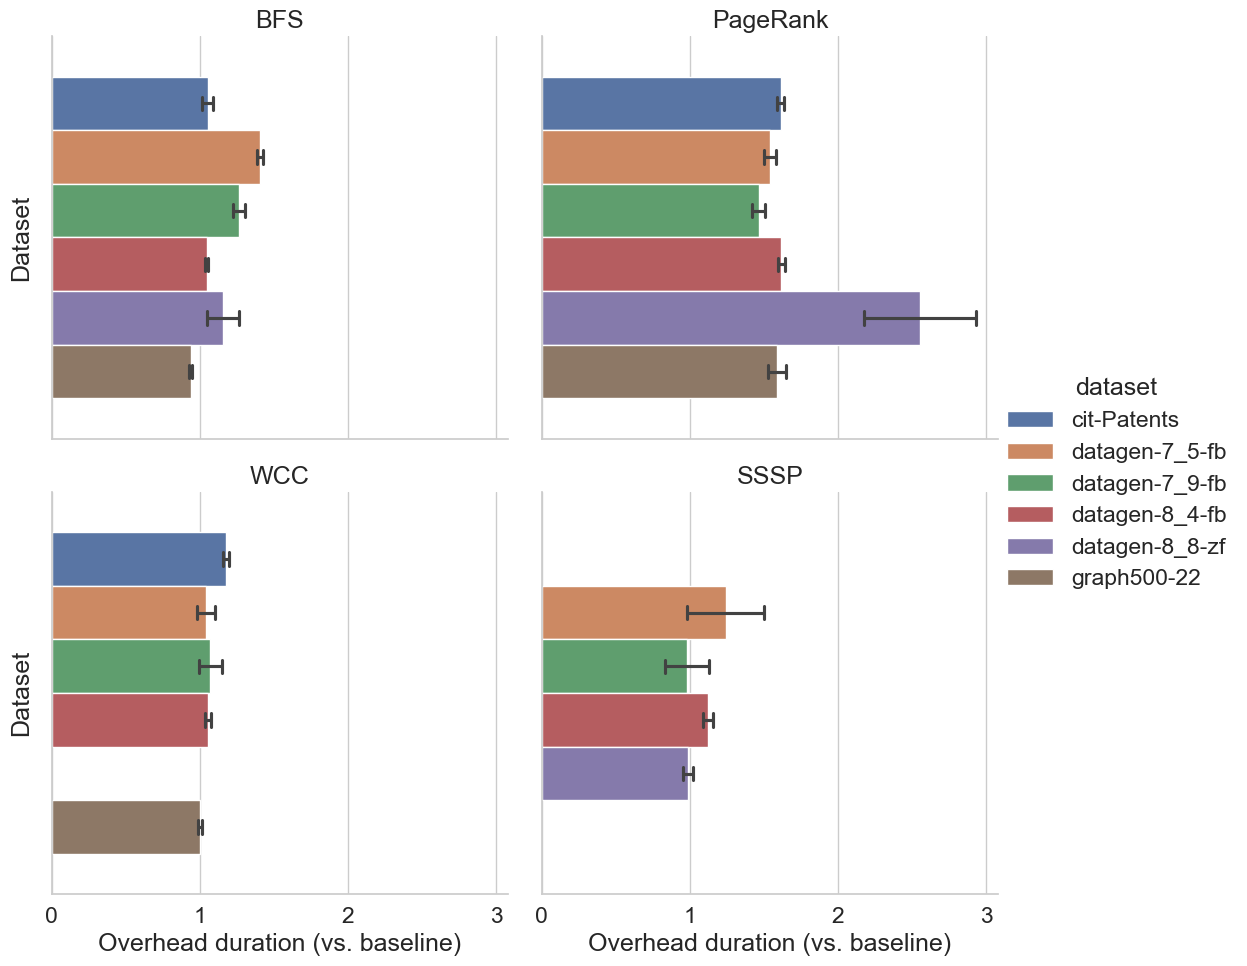

In [53]:
ax = sns.catplot(
    combined_compare,
    x="overhead_duration",
    col="algorithm",
    hue="dataset",
    kind="bar",
    #hue_order=['datagen-7_5-fb', 'graph500-22', 'datagen-7_9-fb', 'cit-Patents', 'datagen-8_4-fb', 'datagen-8_8-zf'],
    col_order=["BFS", "PageRank", "WCC", "SSSP"],
    legend_out=True,
    errorbar="sd",
    capsize=0.2,
    col_wrap=2,
)
# sns.move_legend(ax, "center right", ncols=1, bbox_to_anchor=(1.05, 0.55), title=None, frameon=False)

ax.set_axis_labels("Overhead duration (vs. baseline)", "Dataset")
ax.set_titles("{col_name}")

ax.savefig(plot_location("es06-overhead-duration.pdf"), dpi="figure")

## Size

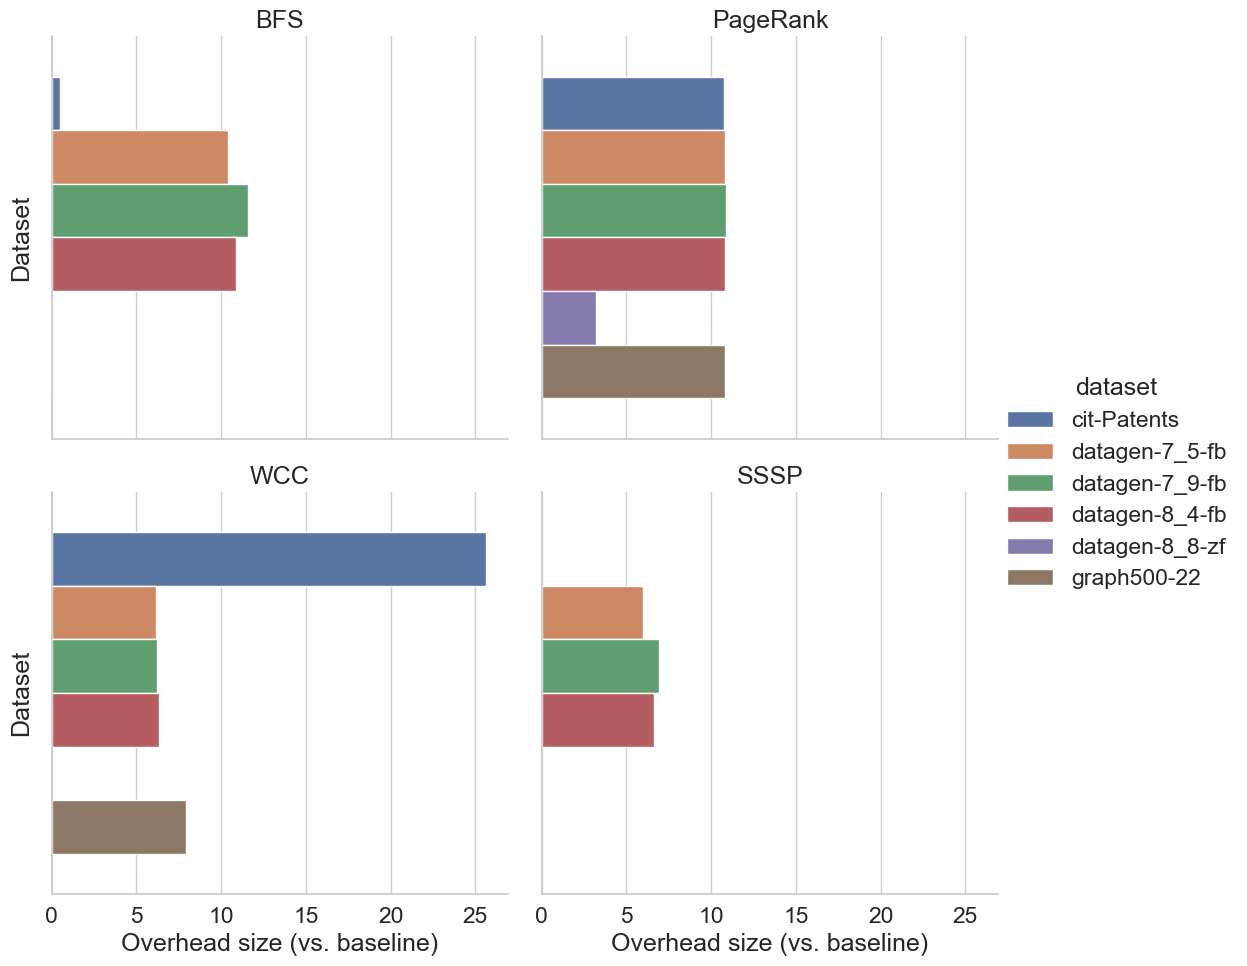

In [54]:
ax = sns.catplot(
    combined_compare,
    x="overhead_size",
    col="algorithm",
    hue="dataset",
    kind="bar",
    #hue_order=['datagen-7_5-fb', 'graph500-22', 'datagen-7_9-fb', 'cit-Patents', 'datagen-8_4-fb', 'datagen-8_8-zf'],
    col_order=["BFS", "PageRank", "WCC", "SSSP"],
    legend_out=True,
    errorbar=None,
    capsize=0.2,
    col_wrap=2,
)
# sns.move_legend(ax, "center right", ncols=1, bbox_to_anchor=(1.05, 0.55), title=None, frameon=False)

ax.set_axis_labels("Overhead size (vs. baseline)", "Dataset")
ax.set_titles("{col_name}")

ax.savefig(plot_location("es06-overhead-size.pdf"), dpi="figure")

# Comparison of all methods

In [121]:
data = json.loads(open("../data/sizes.json").read())
rows = []
for dataset, metrics in data.items():
    s = 0
    for algorithm, size in metrics.items():
        if algorithm not in ["edges", "vertices"]:
            continue
        s += size
    rows.append({"dataset": dataset, "size": s})

dataset_sizes = pd.DataFrame(rows)
dataset_sizes
# graph_size = dataset_sizes.groupby(["algorithm"]).agg(["sum"]).reset_index()
# node_sizes["pretty_size"] = [f"{int(format_filesize(x)[0])}{format_filesize(x)[1]}" for x in node_sizes["size"]["sum"]]
# node_sizes

,dataset,size
0,cit-Patents,294044883
1,datagen-7_5-fb,1063374413
2,datagen-7_9-fb,2659266462
3,datagen-8_4-fb,8383838706
4,datagen-8_8-zf,14974905842
5,graph500-22,1009928153


In [122]:
baseline_stats_2 = baseline_stats.copy(deep=True)
baseline_stats_2 = baseline_stats_2[["algorithm", "dataset", "mean"]].rename(columns={"mean": "duration"})
baseline_stats_2 = pd.merge(baseline_stats_2, dataset_sizes, on=["dataset"])
baseline_stats_2

,algorithm,dataset,duration,size
0,BFS,cit-Patents,82.968899,294044883
1,PageRank,cit-Patents,85.102944,294044883
2,WCC,cit-Patents,157.944986,294044883
3,BFS,datagen-7_5-fb,34.323108,1063374413
4,PageRank,datagen-7_5-fb,39.980476,1063374413
5,SSSP,datagen-7_5-fb,38.116547,1063374413
6,WCC,datagen-7_5-fb,36.768406,1063374413
7,BFS,datagen-7_9-fb,69.310011,2659266462
8,PageRank,datagen-7_9-fb,69.879073,2659266462
9,SSSP,datagen-7_9-fb,76.495710,2659266462


In [123]:
complete_provenance_comp_text = storage_formats[storage_formats["storage_format"] == "Text"].rename(columns={"total_size": "size"})

In [124]:
# baseline
baseline_all_comp = baseline_stats_2.copy(deep=True)
baseline_all_comp["scenario"] = "Baseline"

# tracing, need to combine this with baseline size data
tracing_all_comp = tracing.copy(deep=True)
tracing_all_comp["size"] = 0.1
tracing_all_comp["scenario"] = "ES02"

# complete provenance
complete_provenance_comp = complete_provenance_comp_text.copy(deep=True)
complete_provenance_comp["scenario"] = "ES03 (text)"

# provenance graph pruning
pg_pruning_all_comp = pg_pruning.copy(deep=True)
pg_pruning_all_comp["scenario"] = "ES04"

# data graph pruning
dg_pruning_all_comp = dg_pruning.copy(deep=True)
dg_pruning_all_comp["scenario"] = "ES05"

# combined pruning
combined_all_comp = combined.copy(deep=True)
combined_all_comp["scenario"] = "ES06"
#combined

all_comp = pd.concat([
    baseline_all_comp,
    tracing_all_comp,
    complete_provenance_comp,
    pg_pruning_all_comp,
    dg_pruning_all_comp,
    combined_all_comp,
], ignore_index=True)[["scenario", "algorithm", "dataset", "duration", "size"]]


In [125]:
ax = sns.boxplot(all_comp, x="duration", y="scenario")

ax.set_ylabel("Scenario")
ax.set_xlabel("Duration (s)")


plt.savefig(plot_location("summary-duration.pdf"), dpi="figure", bbox_inches="tight")
plt.clf()

<Figure size 640x480 with 0 Axes>

In [126]:
f_all_comp = all_comp[all_comp["size"] > 2**20]
ax = sns.boxplot(f_all_comp, x="size", y="scenario")

ax.set(xscale="log")
# sns.move_legend(ax, "center right", ncols=1, bbox_to_anchor=(1.05, 0.55), title=None, frameon=False)

num_xticks = 10  # Specify the number of xticks you want
xtick_min = np.log2(f_all_comp['size'].min())
xtick_max = np.log2(f_all_comp['size'].max())
xticks = np.logspace(xtick_min, xtick_max, num=num_xticks, base=2.0)
ax.set(xticks=xticks)

xtick_labels = [f"{int(format_filesize(x)[0])}{format_filesize(x)[1]}" for x in xticks]
ax.set_xticklabels(xtick_labels, rotation=45)

# for axx in ax.axes.flat:
#     axx.set_xticklabels(xtick_labels, rotation=45)

# ax.set_yticks([])
# ax.set_ylabel(None)


# ax.set_axis_label("Size (bytes)", "Dataset")
ax.set_ylabel("")
ax.set_xlabel("Size (bytes)")

plt.savefig(plot_location("summary-size.pdf"), dpi="figure", bbox_inches="tight")
plt.clf()

<Figure size 640x480 with 0 Axes>